In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image
transform = transforms.ToTensor()

In [2]:
from collections import namedtuple
Optimizer = namedtuple('Optimizer', ('name', 'kwargs'))

In [3]:
class MNISTAutoEncoderDataset(datasets.MNIST):
    
    def __init__(
        self, root, train=True, transform=None, download=False
    ):
        super().__init__(
            root=root, 
            train=train, 
            transform=transform, 
            target_transform=None, 
            download=download
        )
        self.targets = self.data
    
    def __getitem__(self, index):
        img = self.data[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)
        return img, img

In [4]:
train_data = MNISTAutoEncoderDataset(root='data', train=True, download=True, transform=transform)
test_data = MNISTAutoEncoderDataset(root='data', train=False, download=True, transform=transform)

In [5]:
bs = 32

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=2*bs, shuffle=True)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
    
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# img = images[0]
img = np.squeeze(images[0])

In [8]:
img.shape

(28, 28)

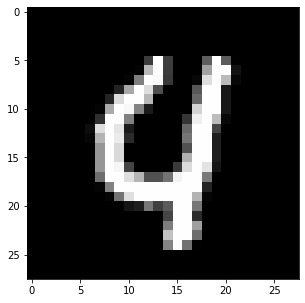

In [9]:
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [10]:
import torch.nn as nn
import torch.nn.functional as F

> The input images will be flattened into 784 length vectors. The targets are the same as the inputs. The encoder and decoder will be made of two linear layers, each. The depth dimensions should change as follows: 784 inputs > encoding_dim > 784 outputs. All layers will have ReLu activations applied except for the final output layer, which has a sigmoid activation.

## Linear Autoencoder

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super().__init__()
        self.encoder = nn.Linear(28*28, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, 28*28)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.encoder(x))
        x = F.sigmoid(self.decoder(x))
        return x.view(-1, 1, 28, 28)

# initialize the NN
encoding_dim = 10
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (encoder): Linear(in_features=784, out_features=10, bias=True)
  (decoder): Linear(in_features=10, out_features=784, bias=True)
)


In [12]:
loss_func = nn.MSELoss()
opt = Optimizer(torch.optim.Adam, {'lr':0.01})

In [13]:
def loss_batch(model, loss_function, xb, yb, opt=None):
    loss = loss_function(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(yb)

In [14]:
def fit(epochs, model, loss_function, optimizer, train_dl, valid_dl):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    device = 'cpu'
    print(f"Training using {device}")
    model.to(device)
    opt = optimizer.name(model.parameters(), **optimizer.kwargs)
    print(f"Optimizer: {opt}")
    for epoch in range(epochs):
        
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_function, xb.to(device), yb.to(device), opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_function, xb.to(device), yb.to(device)) for xb, yb in train_dl]
            )
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            print(f"Epoch: {epoch}, Val Loss: {val_loss}")

In [18]:
fit(10, model, loss_func, opt, train_loader, test_loader)

Training using cpu
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


/home/niyas/.local/share/virtualenvs/pytorch-notes-5uqAFV5U/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0, Val Loss: 0.03537065222163995
Epoch: 1, Val Loss: 0.03502865821520487
Epoch: 2, Val Loss: 0.034728241205215456
Epoch: 3, Val Loss: 0.03494968111316363
Epoch: 4, Val Loss: 0.035056261176864306
Epoch: 5, Val Loss: 0.03463200207948685
Epoch: 6, Val Loss: 0.034564105744163194
Epoch: 7, Val Loss: 0.034783746651808424
Epoch: 8, Val Loss: 0.03470368308722973
Epoch: 9, Val Loss: 0.034901339177290595


In [21]:
def show_samples(model, n_samples=10):
    model.eval()
    model.cpu()
    with torch.no_grad():
        xb, yb = next(iter(test_loader))
        xb = xb[:n_samples]
        pred = np.squeeze(model(xb).numpy(), axis=1)
        orig = np.squeeze(yb.numpy(),axis=1)
        fig, ax = plt.subplots(n_samples, 2, figsize=(4,15))
        for i, row in enumerate(ax):
            row[0].imshow(orig[i], cmap='gray',)
            row[0].axis('off')
            row[1].imshow(pred[i], cmap='gray')
            row[1].axis('off')
        plt.show()

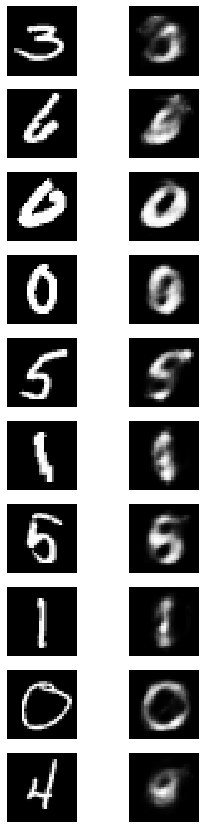

In [20]:
show_samples(model)

## Convolutional Autoencoder

In [15]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        
        # encoder
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # decoder
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))        
        return x

In [16]:
model_conv = ConvAutoencoder()

In [18]:
fit(10, model_conv, loss_func, opt, train_loader, test_loader)

Training using cpu
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


/home/niyas/.local/share/virtualenvs/pytorch-notes-5uqAFV5U/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0, Val Loss: 0.02278330911497275
Epoch: 1, Val Loss: 0.021696229226390522
Epoch: 2, Val Loss: 0.02127303618391355
Epoch: 3, Val Loss: 0.020877083547910055
Epoch: 4, Val Loss: 0.02075252483189106
Epoch: 5, Val Loss: 0.020972514960169792
Epoch: 6, Val Loss: 0.020709781913956005
Epoch: 7, Val Loss: 0.020634572014212607
Epoch: 8, Val Loss: 0.020251181744535763
Epoch: 9, Val Loss: 0.02030631777147452


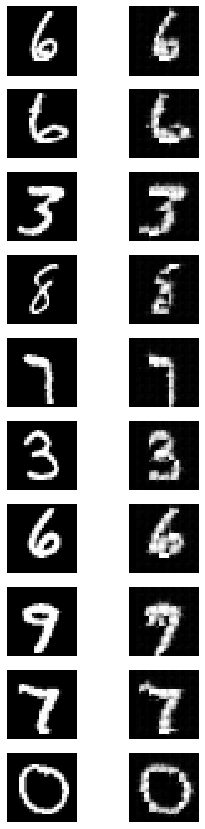

In [52]:
show_samples(model_conv, 10)

In [40]:
def total_parameters(model):
    print([x.shape for x in model.parameters()])
    return np.sum([x.numel() for x in model.parameters()])

In [41]:
total_parameters(model)

[torch.Size([10, 784]), torch.Size([10]), torch.Size([784, 10]), torch.Size([784])]


16474

In [42]:
total_parameters(model_conv)

[torch.Size([16, 1, 3, 3]), torch.Size([16]), torch.Size([4, 16, 3, 3]), torch.Size([4]), torch.Size([4, 16, 2, 2]), torch.Size([16]), torch.Size([16, 1, 2, 2]), torch.Size([1])]


1077